In [8]:
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import perf_counter
import gensim
import math
import pprint
from collections import defaultdict
from numba import jit
from funk_svd import SVD
import warnings
import pickle
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

In [9]:
ratings = pd.read_csv('data/ratings.csv')

In [2]:
movies = pd.read_csv('data/movies.csv')

tags = pd.read_csv('data/tags.csv')
genres = pd.read_csv('data/genres.csv')


In [11]:
person_c = CategoricalDtype(sorted(ratings.userId.unique()), ordered=True)
thing_c = CategoricalDtype(sorted(ratings.movieId.unique()), ordered=True)

row = ratings.userId.astype(person_c).cat.codes
col = ratings.movieId.astype(thing_c).cat.codes
sparse_matrix = csr_matrix((ratings["rating"], (row, col)), \
                           shape=(person_c.categories.size, thing_c.categories.size))
# sparse_matrix.todense()

dfs = pd.SparseDataFrame(sparse_matrix, \
                         index=person_c.categories, \
                         columns=thing_c.categories, \
                         default_fill_value=0)

1       2       3       4       5       6       7       8       9       \
1     0.0     3.5     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     4.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     3.0     0.0     0.0     0.0   
5     0.0     3.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   10      ...  131241  131243  131248  131250  131252  131254  131256  \
1     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     4.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   131258  131260  131262  
1     0.0     0.0     0.0  
2     0.0     0.0     0.0  
3     0.0     0.0     0.0  
4     0.0     0.0     0.0  
5     0.0     0.0     0.0  

[5 rows x 26744 columns]

In [43]:
start = perf_counter()
p=dfs.iloc[0,1]
print(p)
end = perf_counter()
print(end-start)
start = perf_counter()
p=ratings[ratings["userId"]==1]
p = p[p["movieId"]==2]
print(p)
end = perf_counter()
print(end-start)

3.5
0.0005605999999716005
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
0.07040349999988393


In [4]:
# merging movies and users data just like in sql datsets
data = pd.merge(left=movies, right=ratings, on='movieId')
# droping duplicated items
data.drop_duplicates(inplace=True)
tags.drop_duplicates(inplace=True)

In [4]:
print(data.head())

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       3     4.0   944919407  
1       6     5.0   858275452  
2       8     4.0   833981871  
3      10     4.0   943497887  
4      11     4.5  1230858821  


In [5]:
print(data.isna().sum())
# droping NaN and null items
tags.dropna(inplace=True)
tags.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [6]:
data.isna().sum()
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [5]:
years = []
# filling missing values with outliers
for title in data['title']:
    # next line extracts year number from title
    year_subset = title[-5:-1]
    # if it doesnt have a year fill it with 9999 (outlier)
    try: years.append(int(year_subset))
    except: years.append(9999)

data['moviePubYear'] = years
print(len(data[data['moviePubYear'] == 9999]))
data.to_csv('./data/mergedData.csv')

1222


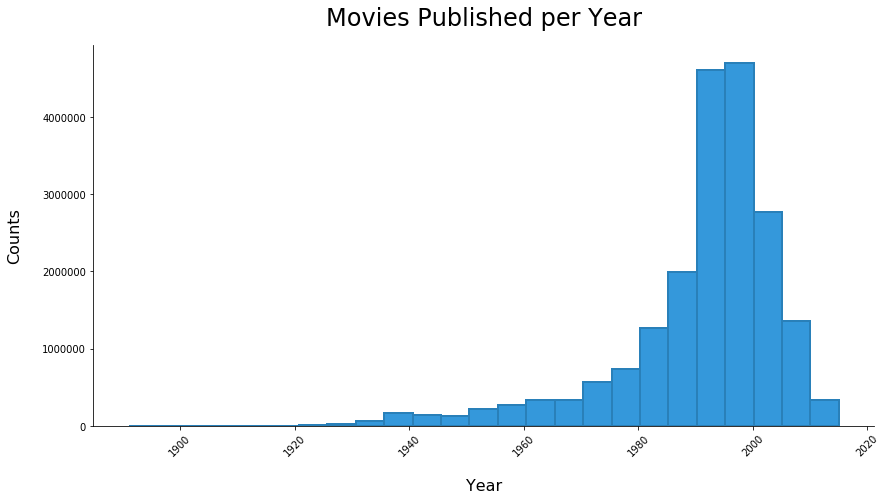

In [24]:
# create a histogram of published years (not necessary)
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        dataset = dataset[dataset['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    
    
make_histogram(data, 'moviePubYear', title='Movies Published per Year', xlab='Year', ylab='Counts')

In [34]:
# performing equal width binning on published years
# it creates intervals (bins) and assigns each item to one of them
def create_bin_year(num):
    years = [year for year in data['moviePubYear'] if year!=9999]
#     print((years))
    # N: number of intervals (bins)
    N = len(np.unique(years))
    width = (max(years)-min(years))/(1.33*math.log(N))
#     print(width)
#     print(num-min(years))
    return (math.floor((num-min(years))/width))

In [37]:
# create_bin_rate(3)

create_bin_year(1995)



19.54291470633722
8099


414

In [9]:
# train test splitting (turns out not useful for RS)
xs = data
ys = data[['userId','movieId','rating']]
x_train,x_test,y_train,y_test = train_test_split(xs,ys,test_size=0.0001,shuffle=True)

In [10]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.0001,shuffle=True)

In [11]:
x_train = x_train.sample(n=20000)

In [6]:
tags_title_dict = {}
for i in range(len(tags)):
    try: tags_title_dict[tags.iloc[i]['movieId']]=tags_title_dict[tags.iloc[i]['movieId']]+' '+tags.iloc[i]['tag']
    except: tags_title_dict[tags.iloc[i]['movieId']]=tags.iloc[i]['tag']
# for i in range(len(movies)):
#     try: tags_title_dict[movies.iloc[i]['movieId']]=tags_title_dict[movies.iloc[i]['movieId']]+' '+movies.iloc[i]['title']
#     except: tags_title_dict[movies.iloc[i]['movieId']]=movies.iloc[i]['title']
# movies.iloc[150]['movieId']

In [7]:
tags_title_df=pd.DataFrame.from_dict(tags_title_dict,orient='index')

In [8]:
tags_title_df.to_csv('./data/titles.csv')

In [9]:
genres_doc_list = movies['genres'].to_numpy()
tags_doc_list = tags['tag'].to_numpy()
doc_list = movies['title'].to_numpy()

In [10]:
tags_title_doc = tags_doc_list

In [5]:
genres_doc_list

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance', ..., 'Adventure',
       '(no genres listed)', 'Adventure|Fantasy|Horror'], dtype=object)

In [6]:
tags_title_doc=[]
tags_title_doc=np.append(tags_title_doc,tags_doc_list)
tags_title_doc=np.append(tags_title_doc,doc_list)

In [11]:
# this block tokenizes every feature
# perf_counter is used to determine how long does every code block takes to complete
start = perf_counter()
# fetching a list of meaningless common english words to delete from docs (we have to do it for persian too)
stoplist = nltk.corpus.stopwords.words('english')
# simple_preprocess lower cases the words and tokenizes them
genres_doc_tokenized = [gensim.utils.simple_preprocess(doc) for doc in genres_doc_list]
tags_title_doc_tokenized = [gensim.utils.simple_preprocess(tags_title_dict[doc]) for doc in sorted(tags_title_dict.keys())]
end = perf_counter()
print(str(end-start))

3.244393300000411


In [29]:
len(tags_title_doc_tokenized)

19545

In [12]:
# defaultdict is just a high performance dictionary
# creating a dictionary implying frequency for each word
frequency = defaultdict(int)
# doc_tokenized = [[word for word in doc if word not in stoplist]for doc in doc_tokenized]
# creating gensim dictionary out of tokenized documents
# Dictionary encapsulates the mapping between normalized words and their integer ids.
# dictionary = gensim.corpora.Dictionary(doc_tokenized)
genres_doc_tokenized = [[word for word in doc if word not in stoplist]for doc in genres_doc_tokenized]
genres_dictionary = gensim.corpora.Dictionary(genres_doc_tokenized)
tags_title_doc_tokenized = [[word for word in doc if word not in stoplist]for doc in tags_title_doc_tokenized]
tags_title_dictionary = gensim.corpora.Dictionary(tags_title_doc_tokenized)
# doc_tokenized = [doc for doc in doc_tokenized if len(doc)!=0]

In [13]:
genres_dictionary[len(genres_dictionary)-2]
tags_title_dictionary.save('./data/title_dictionary.plk')
genres_dictionary.save('./data/genres_dictionary.plk')

In [19]:
warnings.warn('movieId starts from 1 so when you sort tags_title_dict the index is one more than usual')

c:\users\padideh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: movieId starts from 1 so when you sort tags_title_dict the index is one more than usual
  """Entry point for launching an IPython kernel.


In [14]:
start = perf_counter()
# creating bow corpus (allow_updates=True because we should be able to update it when we add a new item to database)
# BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]
genres_BoW_corpus = [genres_dictionary.doc2bow(doc, allow_update=True) for doc in genres_doc_tokenized]
tags_title_BoW_corpus = [tags_title_dictionary.doc2bow(doc, allow_update=True) for doc in tags_title_doc_tokenized]
end = perf_counter()
print(str(end-start))

1.590533300000061


In [44]:
genres_BoW_corpus[len(genres_BoW_corpus)-2]

[(21, 1), (22, 1)]

In [21]:
# pprint is just for pretty printing :D
pprint.pprint(tags_title_BoW_corpus[0])

[(0, 1),
 (1, 2),
 (2, 10),
 (3, 5),
 (4, 1),
 (5, 11),
 (6, 73),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 4),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 5),
 (19, 19),
 (20, 7),
 (21, 5),
 (22, 1),
 (23, 1),
 (24, 13),
 (25, 20),
 (26, 1),
 (27, 1),
 (28, 29),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 14),
 (37, 1),
 (38, 8),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 3),
 (44, 1),
 (45, 2),
 (46, 1),
 (47, 2),
 (48, 18),
 (49, 1),
 (50, 23),
 (51, 1),
 (52, 1),
 (53, 11),
 (54, 1),
 (55, 5),
 (56, 1),
 (57, 3),
 (58, 1),
 (59, 2),
 (60, 3),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 6),
 (68, 1),
 (69, 1),
 (70, 82),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 3),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 2),
 (82, 5),
 (83, 12),
 (84, 23),
 (85, 1),
 (86, 5),
 (87, 3),
 (88, 15),
 (89, 11),
 (90, 2),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 2),
 (96, 1),
 (97, 1),
 (98, 2),
 (99

In [15]:
# saving coupus to a file
# gensim.corpora.MmCorpus.serialize('./data/BoW_corpus.mm', BoW_corpus)
gensim.corpora.MmCorpus.serialize('./data/genres_BoW_corpus.mm', genres_BoW_corpus)
gensim.corpora.MmCorpus.serialize('./data/title_BoW_corpus.mm', tags_title_BoW_corpus)

In [16]:
start = perf_counter()
# fitting tdidf model to bow corpus
# tfidf = gensim.models.TfidfModel(BoW_corpus)
genres_tfidf = gensim.models.TfidfModel(genres_BoW_corpus)
tags_title_tfidf = gensim.models.TfidfModel(tags_title_BoW_corpus)
end = perf_counter()
print(str(end-start))
# print(BoW_corpus)

0.396628999999848


In [17]:
genres_tfidf.save('./data/genres_tfidfModel.mm')
tags_title_tfidf.save('./data/title_tfidfModel.mm')

In [18]:
# applying tfidf on corpus and generating tfidf corpus (can be applied on a single item too)
# this is like predicting function of a ML model
# corpus_tfidf = tfidf[BoW_corpus]
genres_corpus_tfidf = genres_tfidf[genres_BoW_corpus]
tags_title_corpus_tfidf = tags_title_tfidf[tags_title_BoW_corpus]
# print(len(corpus_tfidf))
# for doc in tags_title_corpus_tfidf[0:1]:

In [19]:
# fitting LSA (LSI) to tdidf models

start = perf_counter()
# lsi_model = gensim.models.lsimodel.LsiModel(
#    corpus=corpus_tfidf
# )
genres_lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=genres_corpus_tfidf,
    num_topics=10
)
tags_title_lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=tags_title_corpus_tfidf,
    num_topics=20
)
end = perf_counter()
print(str(end-start))

10.82266940000045


In [20]:
# applying lsi models on tfidf corpus
# doc_lsi = lsi_model[corpus_tfidf]
genres_doc_lsi=genres_lsi_model[genres_corpus_tfidf]
tags_title_doc_lsi=tags_title_lsi_model[tags_title_corpus_tfidf]
# print(len(genres_lsi_model.print_topics()))
# print(lsi_model.print_topics())

In [56]:
genres_doc_lsi[27260]

[(0, 0.023578163753781176),
 (1, 0.021820601130230814),
 (2, 0.19921375506633687),
 (3, 0.016048448164704444),
 (4, -0.00019166029728609962),
 (5, -0.13968190080894335),
 (6, 0.46550390499537514),
 (7, -0.2961717698041382),
 (8, -0.7643852164873621),
 (9, 0.0017176053392755624)]

In [21]:
tags_title_lsi_df=pd.DataFrame(tags_title_doc_lsi)

In [23]:
def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [24]:
save_obj(tags_title_doc_lsi,'titleResults')
save_obj(genres_doc_lsi,'genresResults')

In [25]:
save_obj(tags_title_dict,'titleDict')

In [26]:
tags_title_lsi_df.to_csv('./data/titleLsiResult.csv')

In [77]:
genres_lsi_df=pd.DataFrame(genres_doc_lsi)
genres_lsi_df.to_csv('./data/genresLsiResult.csv')

In [27]:
# saving lsi models
# lsi_model.save('./data/LSAModel.mm')
genres_lsi_model.save('./data/genres_LSAModel.mm')
tags_title_lsi_model.save('./data/title_LSAModel.mm')

In [46]:
print(x_train['userId'].nunique()*x_train['movieId'].nunique())
mat_df = x_train[['userId','movieId','rating']]

75470172


In [47]:
# creating a table that we want to use for MF (ALS)
# this is the memory-intensive part
def make_pivot(mydf):
    mat = mydf.pivot_table(values="rating",index='userId',columns='movieId')
    return mat

In [48]:
table=make_pivot(mat_df)

In [49]:
table.to_csv('./data/matrix_small.csv')

In [78]:
#creating dataframes from numpy arrays
y_train = y_train.to_frame()
y_test = y_test.to_frame()
y_cv = y_cv.to_frame()
y_test.head()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [36]:
# mat.to_csv('./data/matrix.csv')
y_train.to_csv('./data/y_train.csv')
x_test.to_csv('./data/x_test.csv')
x_cv.to_csv('./data/x_cv.csv')
y_cv.to_csv('./data/y_cv.csv')
# y_train.loc[6116412]
# x_train.head()

In [114]:
y_test.to_csv('./data/y_test.csv')
# x_test.head()
# y_test.head()
# x_cv.head()
# y_cv.head()

In [30]:
def get_item_features(movieId,tags_title_doc_lsi,genres_doc_lsi,tags_title_dict,movies):
    con = []
    try:
        tag_lsi = [x[1] for x in tags_title_doc_lsi[sorted(tags_title_dict).index(movieId)]]
        genres_lsi = [x[1] for x in genres_doc_lsi[movies[movies['movieId']==movieId].index[0]]]
        con = np.append(tag_lsi,genres_lsi)
#         print(len(con))
    except:
        print("movieId error")
    return con

In [41]:
get_item_features(15,tags_title_doc_lsi,genres_doc_lsi,tags_title_dict,movies)

array([ 0.0024187 ,  0.0027333 ,  0.00637314, -0.00488073,  0.01765539,
        0.01574026,  0.02086214,  0.02990713,  0.00412866, -0.00833819,
        0.0027032 , -0.00824714, -0.00366203,  0.0078341 ,  0.01307701,
        0.00471515, -0.00916372,  0.00337164,  0.00550476,  0.00125386,
        0.17906217,  0.14428364,  0.2945785 ,  0.05744996,  0.49935511,
        0.27572991,  0.52520252,  0.05546553,  0.27510318,  0.03851909])

In [4]:
genres_results=pd.read_csv('./data/genresLsiResult.csv')

In [6]:
genres_results=genres_results.to_numpy()

In [41]:
len(genres_results)

27278

In [65]:
genres_result=[[eval(results[x]) if not pd.isnull(results[x]) else np.nan for x in range(1,len(results))] for results in genres_results]

In [67]:
genres_result[len(genres_result)-2]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]